In [32]:
import prometheus_pandas.ipython.magic
from prometheus_pandas import query
from matplotlib import pyplot as plt
import pandas as pd

In [33]:
#%%prometheus_query http://localhost:9090 
#    prom_histogram_bucket

In [34]:
p = query.Prometheus('http://localhost:9090')

In [35]:
p.query('prom_histogram_bucket')

prom_histogram_bucket{instance="host.docker.internal:9184",job="HistogramTest",le="+Inf"}    14039.0
prom_histogram_bucket{instance="host.docker.internal:9184",job="HistogramTest",le="1"}        2798.0
prom_histogram_bucket{instance="host.docker.internal:9184",job="HistogramTest",le="2"}        5594.0
prom_histogram_bucket{instance="host.docker.internal:9184",job="HistogramTest",le="3"}        8413.0
prom_histogram_bucket{instance="host.docker.internal:9184",job="HistogramTest",le="4"}       11215.0
prom_histogram_bucket{instance="host.docker.internal:9184",job="HistogramTest",le="5"}       14039.0
dtype: float64

In [36]:
df = p.query('prom_histogram_bucket[1m]')
df

,"prom_histogram_bucket{instance=""host.docker.internal:9184"",job=""HistogramTest"",le=""+Inf""}","prom_histogram_bucket{instance=""host.docker.internal:9184"",job=""HistogramTest"",le=""1""}","prom_histogram_bucket{instance=""host.docker.internal:9184"",job=""HistogramTest"",le=""2""}","prom_histogram_bucket{instance=""host.docker.internal:9184"",job=""HistogramTest"",le=""3""}","prom_histogram_bucket{instance=""host.docker.internal:9184"",job=""HistogramTest"",le=""4""}","prom_histogram_bucket{instance=""host.docker.internal:9184"",job=""HistogramTest"",le=""5""}"
2023-06-23 18:43:11.947999954,13930.0,2777.0,5548.0,8345.0,11129.0,13930.0
2023-06-23 18:43:16.951999903,13940.0,2781.0,5553.0,8353.0,11138.0,13940.0
2023-06-23 18:43:21.950000048,13950.0,2782.0,5557.0,8361.0,11148.0,13950.0
2023-06-23 18:43:26.950999975,13960.0,2783.0,5563.0,8368.0,11156.0,13960.0
2023-06-23 18:43:31.947999954,13970.0,2784.0,5565.0,8373.0,11163.0,13970.0
2023-06-23 18:43:36.948999882,13979.0,2785.0,5569.0,8379.0,11170.0,13979.0
2023-06-23 18:43:41.950000048,13989.0,2787.0,5575.0,8388.0,11179.0,13989.0
2023-06-23 18:43:46.947999954,13999.0,2791.0,5581.0,8396.0,11187.0,13999.0
2023-06-23 18:43:51.947000027,14009.0,2793.0,5584.0,8400.0,11192.0,14009.0
2023-06-23 18:43:56.948999882,14019.0,2795.0,5588.0,8404.0,11199.0,14019.0


In [37]:
lastMinute = p.query('increase(prom_histogram_bucket[1m])')
lastMinute

{instance="host.docker.internal:9184",job="HistogramTest",le="+Inf"}    118.906929
{instance="host.docker.internal:9184",job="HistogramTest",le="1"}        22.908674
{instance="host.docker.internal:9184",job="HistogramTest",le="2"}        50.180906
{instance="host.docker.internal:9184",job="HistogramTest",le="3"}        74.180469
{instance="host.docker.internal:9184",job="HistogramTest",le="4"}        93.816476
{instance="host.docker.internal:9184",job="HistogramTest",le="5"}       118.906929
dtype: float64

In [38]:
df.iloc[11][2] -  df.iloc[0][2]

46.0

In [39]:
lastMinute = p.query('sum(increase(prom_histogram_bucket[1m])) by (le)')
lastMinute

{le="+Inf"}    118.906929
{le="1"}        22.908674
{le="2"}        50.180906
{le="3"}        74.180469
{le="4"}        93.816476
{le="5"}       118.906929
dtype: float64

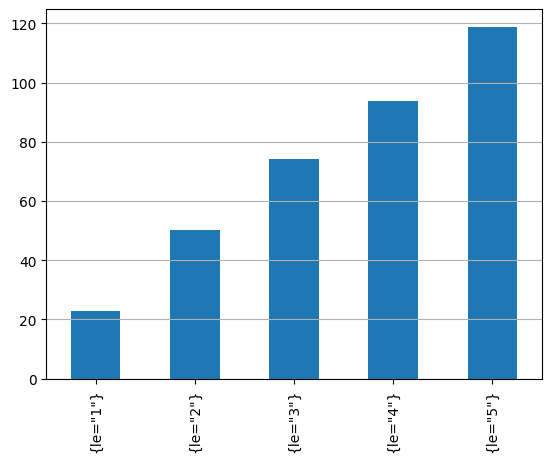

In [53]:
hist = lastMinute[1:].plot(kind='bar')
_ = hist.grid(axis='y');

In [41]:
p.query('histogram_quantile(0.95, increase(prom_histogram_bucket[1m]))') 

{instance="host.docker.internal:9184",job="HistogramTest"}    4.763043
dtype: float64

In [42]:
p.query('histogram_quantile(0.95, sum(increase(prom_histogram_bucket[1m])) by (le))') 

{}    4.763043
dtype: float64

Vi har i alt

lastMinute['{le="5"}']

20 

observationer. 95% fraktil svarer til

In [43]:
0.95 * lastMinute['{le="5"}']

112.9615825166815

Hvilket er et antal observationer inde i bucket 5:

In [44]:
target = 0.95 * lastMinute['{le="5"}'] - lastMinute['{le="4"}']
target

19.145106452609937

Lad os antage, at de observationer som falder i bucket 5 er fordelt ligeligt over bucket 5, så kan vi udregne en hældning:

In [45]:
slope = 1.0 / (lastMinute['{le="5"}'] - lastMinute['{le="4"}'])
slope 

0.0398557971014493

Hvilket bucket indeholder ovenstående request? Det gør bucket 5.

In [46]:
4.0 + slope * target

4.76304347826087

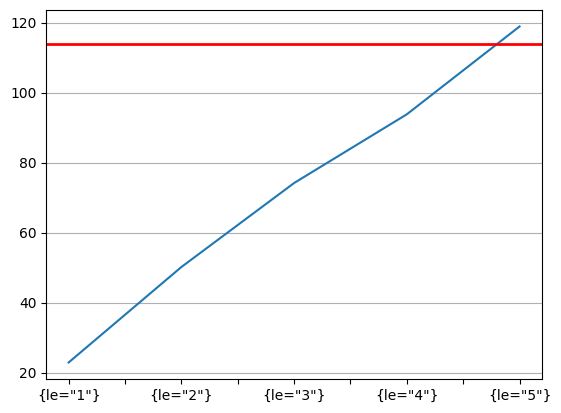

In [47]:
plot = lastMinute[1:].plot(kind='line');
plot.grid(axis='y');
_  = plot.axhline(y=0.95*120, color= 'red', linewidth=2,)